In [45]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import pathlib
import json
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp

symbols_list_file_name = "binance_BTC_from_2019_05_01_to_2022_04_30.json"
with open(symbols_list_file_name, "r") as f:
    symbols_list = json.load(f)
symbols_list.remove('scbtc')

returns_folder_name = "full_returns"
    
ts_list = []
for symbol in symbols_list:
    save_file_name = symbol + '.csv.gz'
    save_path = os.path.join(os.getcwd(), returns_folder_name, save_file_name)
    df = pd.read_csv(save_path, compression='gzip')
    ts_list.append(df['log_return'].rename(symbol))
all_returns_df = pd.concat(ts_list, axis=1)

increment = 30
ticks = 1440 / increment

# calculate asset and market volatilities
squared_returns = all_returns_df.pow(2)
volatilities = squared_returns.groupby(
    squared_returns.index // increment).sum().pow(1./2)
volatilities['market'] = volatilities.mean(axis=1)

r_squareds_list = []
for group, data in volatilities.groupby(volatilities.index % ticks):

    non_market = data.drop(['market'], axis=1)
    r_squareds = non_market.apply(
        lambda x: sp.stats.linregress(data.market, x)
    ).loc[2,:].pow(2).rename(group, inplace=True)

    r_squareds_list.append(r_squareds)

diurnal_commonalities = pd.concat(r_squareds_list, axis=1).transpose()

time_of_day = (
    diurnal_commonalities.index.to_series() * increment * 60
).astype(int).apply(lambda x: dt.datetime.utcfromtimestamp(x).strftime('%H:%M'))

timed_diurnal_commonalities = pd.concat(
    [diurnal_commonalities, time_of_day], axis=1
)

timed_diurnal_commonalities.rename(columns={0: 'time'}, inplace=True)

sns.set(font_scale=1)
molten = timed_diurnal_commonalities.melt(
    'time', var_name='assets', value_name='commonality'
)
plt = sns.lineplot(data=molten, x='time', y='commonality')
plt.set_facecolor('white')
plt.tick_params(bottom=True, left=True)
for i, spine in plt.spines.items():
    spine.set_visible(True)
    spine.set_color('black')

x_axis_tick_frequency = 240
if increment < x_axis_tick_frequency:
    ticks = plt.xaxis.get_major_ticks()
    labels = plt.xaxis.get_ticklabels()
    for i, (label, tick) in enumerate(zip(labels, ticks)):
        if i % int(x_axis_tick_frequency / increment) != 0:
            label.set_visible(False)
            tick.set_visible(False)

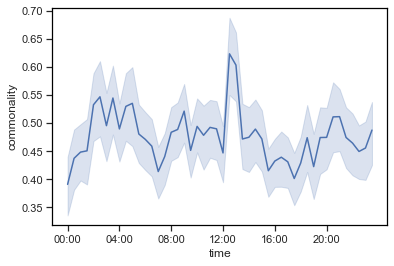

In [46]:
plt.figure

In [47]:
figure_name = 'diurnal_commonality.png'
figures_path_base = 'figures/exploration/raw'
figure_path = os.path.join(figures_path_base, figure_name)
plt.figure.savefig(figure_path, bbox_inches='tight', dpi=300)